In [2]:
import numpy as np
import os
import os.path
import torch, time, os, copy, random, imageio, os, shutil, numpy, zipfile,timm
import matplotlib.pyplot as plt, pandas as pd, seaborn as sn, torch.nn as nn
from torchvision import datasets, models, transforms, utils
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from typing import Any, Callable, cast, Dict, List, Optional, Tuple,Union
from PIL import Image
from torchvision.datasets.vision import VisionDataset
from tqdm import tqdm

# 1 数据分析
通过下面分析可知，基本上每个类别都比原本的IP102-IC数据量有所增加

train中共62509图片,最多的类别有4526张图片,最少的类别有53张图片
val中共10179图片,最多的类别有680张图片,最少的类别有9张图片
test中共31146图片,最多的类别有2335张图片,最少的类别有26张图片


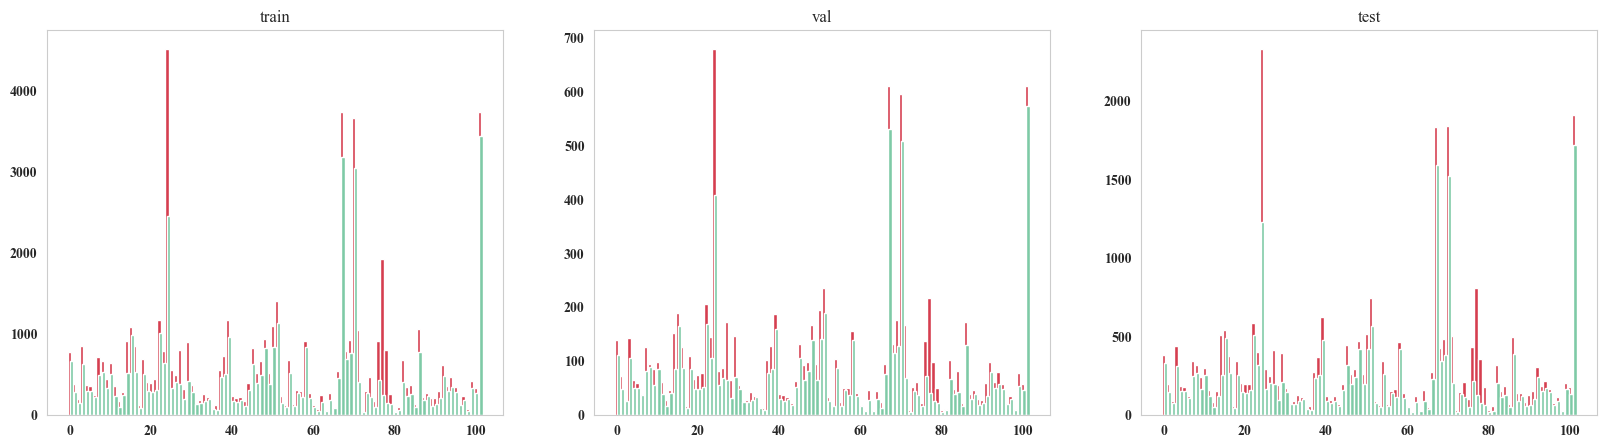

In [3]:
from matplotlib import rcParams
import numpy as np
# 导入字体配置
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
    "font.weight":'bold',
}
rcParams.update(config)
DATA_ROOT_DIR = "./datasets/classification"
num_class=102
all_category = []
cat_num = ["train", "val", "test"]
for i in cat_num:
    per_category_num = []
    folder = os.path.join(DATA_ROOT_DIR, i)
    for iter1 in range(num_class):
        per_category_num.append(len(os.listdir(os.path.join(folder, str(iter1)))))
    all_category.append(per_category_num)
# 绘制柱状图
DATA_ROOT_DIR = "./datasets/yolo_data"
num_class = 102
all_category1 = []
cat_num = ["train", "val", "test"]
for i in cat_num:
    per_category_num = []
    folder = os.path.join(DATA_ROOT_DIR, i)
    for iter1 in range(num_class):
        per_category_num.append(len(os.listdir(os.path.join(folder, str(iter1)))))
    all_category1.append(per_category_num)
# 绘制柱状图
plt.figure(figsize=(20,5))
for i in cat_num:
    plt.subplot(1,3,cat_num.index(i)+1)
    plt.bar(range(len(all_category1[cat_num.index(i)])), all_category1[cat_num.index(i)],label=i,color='#d53e4f')
    # 偏移一些位置
    plt.bar(range(len(all_category[cat_num.index(i)])), all_category[cat_num.index(i)],label=i,align = 'edge',color='#7ecaa6')
    plt.grid(False)
    plt.title(i)
    print(f"{i}中共{sum(all_category1[cat_num.index(i)])}图片,最多的类别有{np.max(all_category1[cat_num.index(i)])}张图片,最少的类别有{np.min(all_category1[cat_num.index(i)])}张图片")

# 2 自定义ImageDataSet与数据增强
## 2.1 自定义ImageDataSet
代码基本逻辑来源于pytorch官方的ImageFolder，但是由于里面好多函数功能缺失，只能自己修改重写了，主要是做了一个数据的重采样以及数据如果超过3000进行部分丢弃，以及一些文件夹对类名的映射，增加了按照PIL的方式读取文件，并且增加了一些辅助函数

In [4]:
IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")
def has_file_allowed_extension(filename: str, extensions: Union[str, Tuple[str, ...]]) -> bool:
    """如果文件名以给定扩展名之一结尾，则为True
    """
    return filename.lower().endswith(extensions if isinstance(extensions, str) else tuple(extensions))
def is_image_file(filename: str) -> bool:
    """检查文件是否是允许的图像扩展名。
    """
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """在数据集中查找类文件夹。
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir()) # 0-102
    if not classes:
        raise FileNotFoundError(f"没有找到对应的{directory}文件夹.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def make_dataset(
        directory: str,
        class_to_idx: Optional[Dict[str, int]] = None,
        extensions: Optional[Union[str, Tuple[str, ...]]] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
) -> List[Tuple[str, int]]:
    """从目录中加载文件路径和类标签对列表。
    """
    directory = os.path.expanduser(directory)
    if class_to_idx is None:
        _, class_to_idx = find_classes(directory)
    elif not class_to_idx:
        raise ValueError("class_to_idx 不能为空")
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    # if both_none or both_something:
    #     raise ValueError("请提供extensions或is_valid_file，但不是两者。")
    if extensions is not None:
        def is_valid_file(x: str) -> bool:
            return has_file_allowed_extension(x, extensions)  # type: ignore[arg-type]
    # 用来判断文件是否是允许的扩展名
    is_valid_file = cast(Callable[[str], bool], is_valid_file)
    instances = []
    available_classes = set()
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            if len(fnames) > 2000:
                fnames = random.sample(fnames, 2000)
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)
                    if target_class not in available_classes:
                        available_classes.add(target_class)
    empty_classes = set(class_to_idx.keys()) - available_classes
    if empty_classes:
        msg = f"Found no valid file for the classes {', '.join(sorted(empty_classes))}. "
        if extensions is not None:
            msg += f"Supported extensions are: {extensions if isinstance(extensions, str) else ', '.join(extensions)}"
        raise FileNotFoundError(msg)
    return instances

class DatasetFolder(VisionDataset):
    """一个通用的数据加载器，从文件夹中加载样本。
    """
    def __init__(
            self,
            root: str,
            loader: Callable[[str], Any],
            extensions: Optional[Tuple[str, ...]] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        classes, class_to_idx = self.find_classes(self.root) # 返回0-102的类名和对应的索引
        samples = self.make_dataset(self.root, class_to_idx, extensions, is_valid_file)

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    @staticmethod
    def make_dataset(
            directory: str,
            class_to_idx: Dict[str, int],
            extensions: Optional[Tuple[str, ...]] = None,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> List[Tuple[str, int]]:
        """生成样本列表，形式为（样本路径，类）。
        """
        # if class_to_idx is None:
        #     raise ValueError("The class_to_idx parameter cannot be None.")
        return make_dataset(directory, class_to_idx, extensions=extensions, is_valid_file=is_valid_file)
    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        """
        """
        return find_classes(directory)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target
    def __len__(self) -> int:
        return len(self.samples)

def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

def default_loader(path: str) -> Any:
    from torchvision import get_image_backend
    return pil_loader(path)
class MyImageFolder(DatasetFolder):
    def __init__(
            self,
            root: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            loader: Callable[[str], Any] = default_loader,
            is_valid_file: Optional[Callable[[str], bool]] = None,
            real_class_name_path: str = None,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples
        self.real_class_name_path = real_class_name_path
    def get_dict_class(self):
        dict_ = {}
        for i in self.imgs:
            if i[1] in dict_.keys():
                dict_[i[1]] += 1
            else:
                dict_[i[1]] = 1
        return dict_
    def get_class_real_name(self):
        dict_ = {}
        real_name_list = []
        if self.real_class_name_path is None:
            return None
        else:
            with open(self.real_class_name_path, 'r') as f:
                lines = f.readlines()
                lines = [i.strip() for i in lines]
            real_name_list = lines
            for k,v in self.class_to_idx.items():#{0:0}
                dict_[v] = real_name_list[int(k)]
            return dict_

## 2.2 数据集加载与数据增强

In [5]:
im_dimention = 224
num_class=102
# 数据增强
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((384,384)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: MyImageFolder(os.path.join(DATA_ROOT_DIR, x),data_transforms[x],real_class_name_path='./datasets/classes.txt')
                  for x in ['train', 'val','test']}

这里需要注意，由于读取文件夹时是按照文件夹的字符串顺序读取的，所以类别顺序进行了调整，这里需要注意。我提供了一个`class_to_idx`可以直接返回对应的类别名称。并且提供了一个`get_dict_class`函数，可以返回每个类别的样本数量。并且提供了一个可以获取对应真实类名的函数`get_class_real_name`，需要传入一个真实类名的txt文件路径。

In [6]:
print(image_datasets['train'].get_dict_class())

{0: 783, 1: 387, 2: 650, 3: 335, 4: 2000, 5: 357, 6: 179, 7: 292, 8: 912, 9: 1089, 10: 854, 11: 127, 12: 695, 13: 410, 14: 196, 15: 400, 16: 451, 17: 1181, 18: 790, 19: 2000, 20: 557, 21: 495, 22: 806, 23: 320, 24: 900, 25: 860, 26: 373, 27: 151, 28: 194, 29: 259, 30: 227, 31: 94, 32: 125, 33: 564, 34: 727, 35: 1176, 36: 379, 37: 243, 38: 213, 39: 224, 40: 178, 41: 393, 42: 835, 43: 524, 44: 674, 45: 941, 46: 525, 47: 359, 48: 1097, 49: 1415, 50: 238, 51: 123, 52: 687, 53: 142, 54: 315, 55: 300, 56: 921, 57: 269, 58: 251, 59: 127, 60: 75, 61: 253, 62: 71, 63: 279, 64: 103, 65: 543, 66: 2000, 67: 798, 68: 935, 69: 722, 70: 2000, 71: 1052, 72: 56, 73: 301, 74: 475, 75: 181, 76: 922, 77: 1931, 78: 803, 79: 258, 80: 670, 81: 53, 82: 102, 83: 682, 84: 346, 85: 375, 86: 140, 87: 1061, 88: 227, 89: 281, 90: 216, 91: 448, 92: 217, 93: 303, 94: 615, 95: 362, 96: 474, 97: 344, 98: 144, 99: 238, 100: 72, 101: 419}


In [7]:
print(image_datasets['train'].class_to_idx)

{'0': 0, '1': 1, '10': 2, '100': 3, '101': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99': 

In [8]:
print(image_datasets['train'].get_class_real_name())

{0: 'ice leaf roller', 1: 'ice leaf caterpillar', 2: 'ice water weevil', 3: 'Sternochetus frigidus', 4: 'Cicadellidae', 5: 'ice leafhopper', 6: 'rain spreader thrips', 7: 'ice shell pest', 8: 'rub', 9: 'ole cricket', 10: 'ireworm', 11: 'hite margined moth', 12: 'lack cutworm', 13: 'arge cutworm', 14: 'addy stem maggot', 15: 'ellow cutworm', 16: 'ed spider', 17: 'orn borer', 18: 'rmy worm', 19: 'phids', 20: 'otosiabre vitarsis', 21: 'each borer', 22: 'nglish grain aphid', 23: 'reen bug', 24: 'ird cherry-oataphid', 25: 'siatic rice borer', 26: 'heat blossom midge', 27: 'enthaleus major', 28: 'onglegged spider mite', 29: 'heat phloeothrips', 30: 'heat sawfly', 31: 'erodonta denticornis', 32: 'eet fly', 33: 'lea beetle', 34: 'abbage army worm', 35: 'eet army worm', 36: 'ellow rice borer', 37: 'eet spot flies', 38: 'eadow moth', 39: 'eet weevil', 40: 'ericaorient alismots chulsky', 41: 'lfalfa weevil', 42: 'lax budworm', 43: 'lfalfa plant bug', 44: 'arnished plant bug', 45: 'ocustoidea', 46

# 3. 加载DataLoader


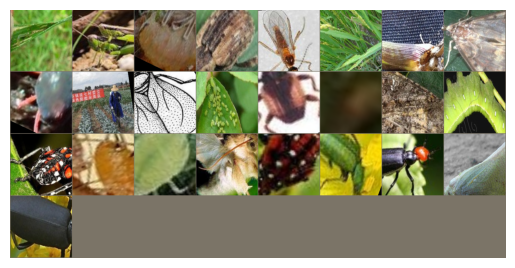

In [9]:
batch_size = 25
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataloaders_test = {'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                             shuffle=False, num_workers=0)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_real_names = image_datasets['train'].get_class_real_name()
# 进行展示
def show_iter_dataloader(fun, title=None):
    """Imshow for Tensor."""
    fun = fun.numpy().transpose((1, 2, 0))
    mean = numpy.array([0.485, 0.456, 0.406])
    std = numpy.array([0.229, 0.224, 0.225])
    fun = std * fun + mean
    fun = numpy.clip(fun, 0, 1)
    plt.imshow(fun)
    plt.axis('off')
    if title is not None:
        plt.title(title)
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
show_iter_dataloader(out)

# 4. 模型训练
## 4.1 加载预训练模型

In [10]:
layer_width = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=num_class)
num_ftrs = model_ft.head.in_features
half_in_size = round(num_ftrs/2)
for layer in model_ft.modules():
    print(layer,end=':')
    for param in layer.parameters():
        print(param.requires_grad,end=' ')
    print()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2): Dropout(p=0.0, inp

## 4.2 构造CBLoss

In [11]:
class CB_Loss(nn.Module):
    def __init__(self, samples_per_cls, no_of_classes, loss_type, beta, gamma):
        super(CB_Loss, self).__init__()
        self.samples_per_cls = samples_per_cls
        self.no_of_classes = no_of_classes
        self.loss_type = loss_type
        self.beta = beta
        self.gamma = gamma
        self.loss_type = "sigmoid"
    def forward(self, logits, labels):
        effective_num = 1.0 - torch.pow(self.beta-self.beta, self.samples_per_cls)# 0.001,0.003,0.006
        weights = (1.0 - self.beta) / torch.tensor(effective_num)# 0.1,0.0334,0.0167
        weights = weights / torch.sum(weights) * self.no_of_classes # 1.999,0.667,0.334
        labels_one_hot = torch.zeros_like(logits).scatter_(1, labels.unsqueeze(1), 1)
        weights = weights.unsqueeze(0).repeat(labels_one_hot.shape[0], 1) * labels_one_hot
        weights = weights.sum(1)
        weights = weights.unsqueeze(1).repeat(1, self.no_of_classes)
        if self.loss_type == "sigmoid":
            cb_loss = F.binary_cross_entropy_with_logits(input=logits,target=labels_one_hot, weight=weights)
        elif self.loss_type == "softmax":
            pred = logits.softmax(dim=1)
            cb_loss = F.binary_cross_entropy(input=pred, target=labels_one_hot, weight=weights)
        return cb_loss

## 4.3 构造头部模型

In [12]:
class SpinalNet(nn.Module):
    def __init__(self):
        super(SpinalNet, self).__init__()
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, num_class+1),)

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))

        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)
        x = self.fc_out(x)
        return x

## 4.4 定义训练与验证函数

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in tqdm(dataloaders[phase],phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # 保存最好的模型参数
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_passed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_passed // 60, time_passed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model_ft.head = SpinalNet()
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
# criterion = CB_Loss(labels=labels, samples_per_cls=samples_per_cls, no_of_classes=num_class, loss_type="softmax", beta=0.9, gamma=2.0)
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)
step_per_epoch = len(dataloaders['train'])
epochs = 16
total_step = step_per_epoch * epochs
exp_lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft,max_lr=0.005,total_steps=total_step,verbose=False,pct_start = 0.03,div_factor=10,final_div_factor=1)
# lr_list = []
# for i in range(total_step):
#     lr_list.append(scheduler.get_last_lr()[0])
#     scheduler.step()
print(f"*********Total epochs:{epochs}, total steps:{total_step}, per step:{step_per_epoch}*********")
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)

## 4.5 验证并保存模型

In [175]:
y_pred = []
y_true = []
output_all =[]
cnt = 0
model_ft.to(device)
model_ft.eval()
with torch.no_grad():
# iterate over test data
    for inputs, labels in tqdm(dataloaders_test['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = model_ft(inputs) # Feed Network
            output = output[:,0:num_class] # Discarding Background Class
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth
            cnt += 1
test_accuracy = 0
for iter1 in range(len(y_true)):
    if y_true[iter1] == y_pred[iter1]:
        test_accuracy = test_accuracy + 1
print('Test Accuracy:',test_accuracy/len(y_true))
torch.save(model_ft.state_dict(), './model/xxxxx.pkl')

  0%|                                                                                                                                                                                  | 0/1233 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 16.00 GiB total capacity; 14.73 GiB already allocated; 0 bytes free; 15.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# 5 结果验证
模型与测试集预测保存在model文件夹下，模型文件保存为.pt格式，预测标签与真实标签对应表为.csv格式，可以下载后直接进行验证
注意验证baseline时需要更换head的结构

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from collections import Counter
model_path = 'model/model_yolo_spinalNet.pt'
model_ft.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [75]:
def test_by_csv(csv_path,class_names):
    result = pd.read_csv(csv_path)
    y_pred = result['Predicted'].values
    y_true = result['True'].values
    print(classification_report(y_true, y_pred, target_names=class_names,digits=4))
    heatmap = np.zeros((102, 102))
    for pred, true in zip(y_pred, y_true):
        heatmap[pred][true] = heatmap[pred][true] + 1
    counts = Counter(y_true)
    counts_list = list(counts.values())
    heatmap_norm = np.divide(heatmap,counts_list)
    # 显示热点图
    plt.figure(figsize=(20,20))
    plt.imshow(heatmap_norm, cmap= 'Spectral_r' , interpolation='nearest', vmin=0, vmax=1)
    plt.xticks(np.arange(102), np.arange(102), rotation=90)
    plt.yticks(np.arange(102), np.arange(102))
    plt.colorbar(shrink=0.8, aspect=20)
    plt.grid(color='white', linestyle='-', linewidth=0.1)
    plt.show()
    return heatmap_norm

## 5.1 验证yolo_spinalNet模型

                                 precision    recall  f1-score   support

                ice leaf roller     0.7399    0.8031    0.7702       386
           ice leaf caterpillar     0.6436    0.6468    0.6452       201
               ice water weevil     0.8415    0.7336    0.7838       304
          Sternochetus frigidus     0.7673    0.6703    0.7155       182
                   Cicadellidae     0.8913    0.8666    0.8787      1911
                 ice leafhopper     0.6082    0.7284    0.6629       162
           rain spreader thrips     0.6966    0.7561    0.7251        82
                 ice shell pest     0.5614    0.6316    0.5944       152
                            rub     0.9008    0.9008    0.9008       514
                    ole cricket     0.9492    0.9667    0.9579       541
                        ireworm     0.8407    0.9098    0.8739       377
             hite margined moth     0.5106    0.3934    0.4444        61
                   lack cutworm     0.6979    0.77

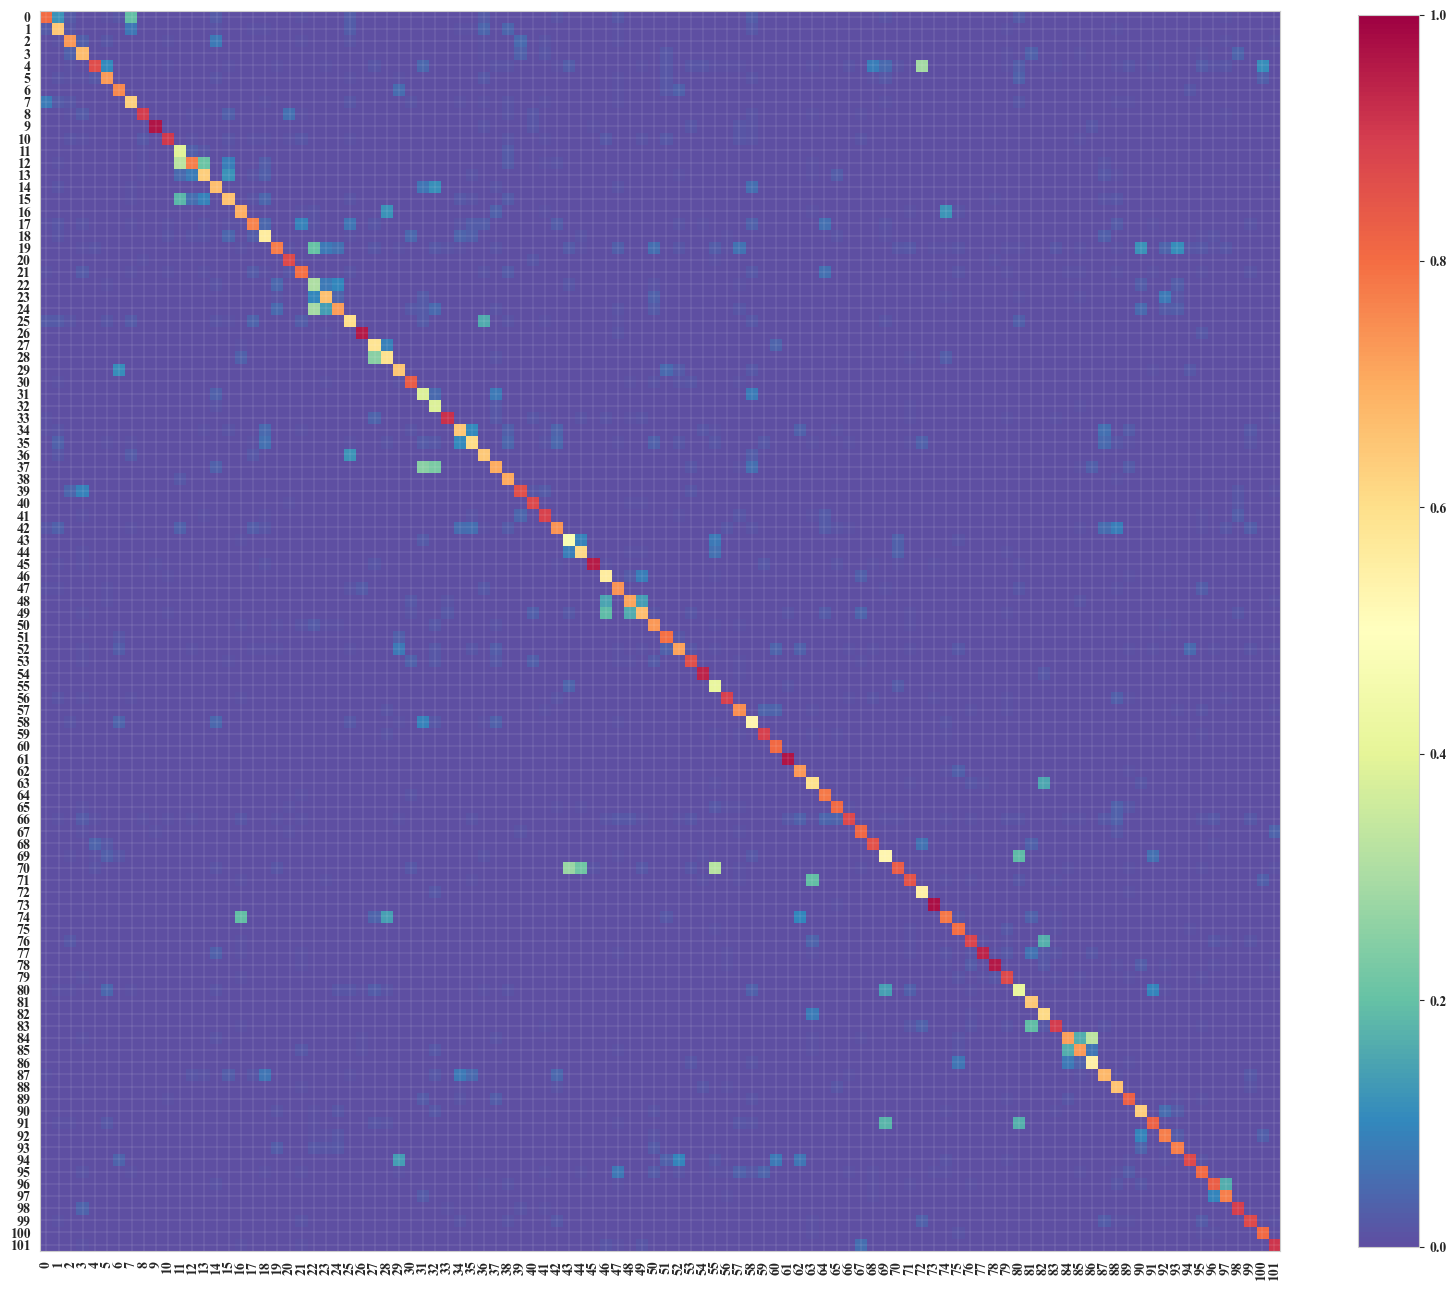

In [76]:
heat_map = test_by_csv('model/label_yolo_spinalNet.csv',class_real_names.values())

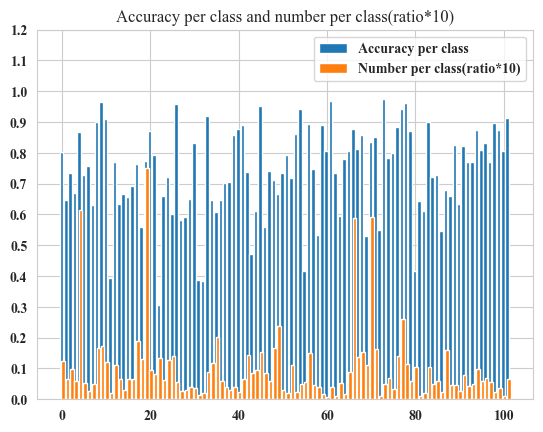

In [171]:
y_true = pd.read_csv('model/label_yolo_spinalNet.csv')['True'].values
counts = Counter(y_true)
counts_list = list(counts.values())
heatmap_norm = np.divide(heat_map,np.sum(heat_map,axis=0))
acc_per_class = np.diag(heatmap_norm)
num_per_class = np.divide(counts_list,np.sum(counts_list))
width = 0.35
x = np.arange(len(acc_per_class))
plt.bar(x - width/2,acc_per_class,label='Accuracy per class')
plt.bar(x + width/2,num_per_class*10,label='Number per class(ratio*10)')
plt.title('Accuracy per class and number per class(ratio*10)')
plt.yticks(np.arange(0, 1.3, 0.1))
plt.legend()

## 5.2 使用投票机制将扩展数据集的预测结果与原始数据集的预测结果进行融合
这里由于在dataloader加载测试集的时候并没有打乱数据，因此实际上扩展数据集的预测结果与原始数据集的预测结果是一一对应的。
我在之前处理数据时，将原始数据集的图片名称与扩展数据集的图片名称进行了对应，比如图片xxxxx.jpg扩展后为xxxxx_0.jpg-xxxxx_n.jpg，我只需要求出这n-1个图片的预测结果，然后按照投票机制选取其中票数最多的标签作为实际预测标签，再与真实标签进行比较

In [143]:
dir_data = './datasets/yolo_data/test'
label = 0
idx = 0
dict_ = {}
for root, dirs, files in os.walk(dir_data):
    # print(f"当前路径下有{len(files)}个文件")
    # print("---------------------------------------------------")
    for file in files:
        # print(file)
        ori_name = file.split('_')[0]
        if ori_name.split('.')[-1] == 'jpg':
            ori_name = ori_name.split('.')[0]
        else:
            if ori_name.split('.')[-1] != ori_name:
                raise ValueError('wrong file name')
        # print(ori_name)
        dict_[idx] = ori_name
        idx += 1
        # break
# for k,v in dict.items():
#     print(k,v)
# for i in dataloaders_test['test'].dataset.imgs:
#     print(i[0])

In [140]:
last_val = 00000
total_img_num = 0
total_img_acc_num = 0
actual_pred_list = []
actual_true_list = []
result = pd.read_csv('model/label_yolo_spinalNet.csv')
y_pred = result['Predicted'].values
y_true = result['True'].values
for y_p,y_t,val in zip(y_pred, y_true, dict_.values()):
    # 每个类都需要有一个正确元素表
    # 如果上一个元素不等于这一个
    # 排除第一个照片00000.jpg
    if val != last_val and last_val != 00000:
        # 选择当前列表中最多的类作为实际选择的label
        actual_pred = max(set(item_pred), key=item_pred.count)
        actual_true = item_true
        actual_pred_list.append(actual_pred)
        actual_true_list.append(actual_true)
        if actual_pred == actual_true:
            total_img_acc_num += 1
        total_img_num += 1
        item_pred = []
        item_pred.append(y_p)
        item_true = y_t
        last_val = val
    else:
        item_pred.append(y_p)
        item_true = y_t
        last_val = val
# 最后一个元素需要手动添加
actual_true_list.append(item_true)
actual_pred = max(set(item_pred), key=item_pred.count)
actual_pred_list.append(actual_pred)

In [141]:
print(classification_report(actual_pred_list,actual_true_list, digits=4))

              precision    recall  f1-score   support

           0     0.8149    0.7319    0.7712       373
           1     0.6531    0.6194    0.6358       155
           2     0.7432    0.8843    0.8076       216
           3     0.6812    0.7581    0.7176       124
           4     0.8920    0.9089    0.9004      1691
           5     0.6967    0.6589    0.6773       129
           6     0.6731    0.6863    0.6796        51
           7     0.6016    0.5606    0.5804       132
           8     0.9070    0.8966    0.9017       261
           9     0.9778    0.9546    0.9661       507
          10     0.8989    0.8571    0.8775       280
          11     0.4667    0.5676    0.5122        37
          12     0.7665    0.6961    0.7296       283
          13     0.6081    0.5143    0.5573       175
          14     0.6835    0.7397    0.7105        73
          15     0.6181    0.5597    0.5875       159
          16     0.7107    0.6975    0.7040       162
          17     0.8039    

这里可以看到总数据量为22619，与原始的IP102的数据总数保持一致。
准去率相较在IP102扩充数据上有所提高

## 5.3 输入图片进行预测

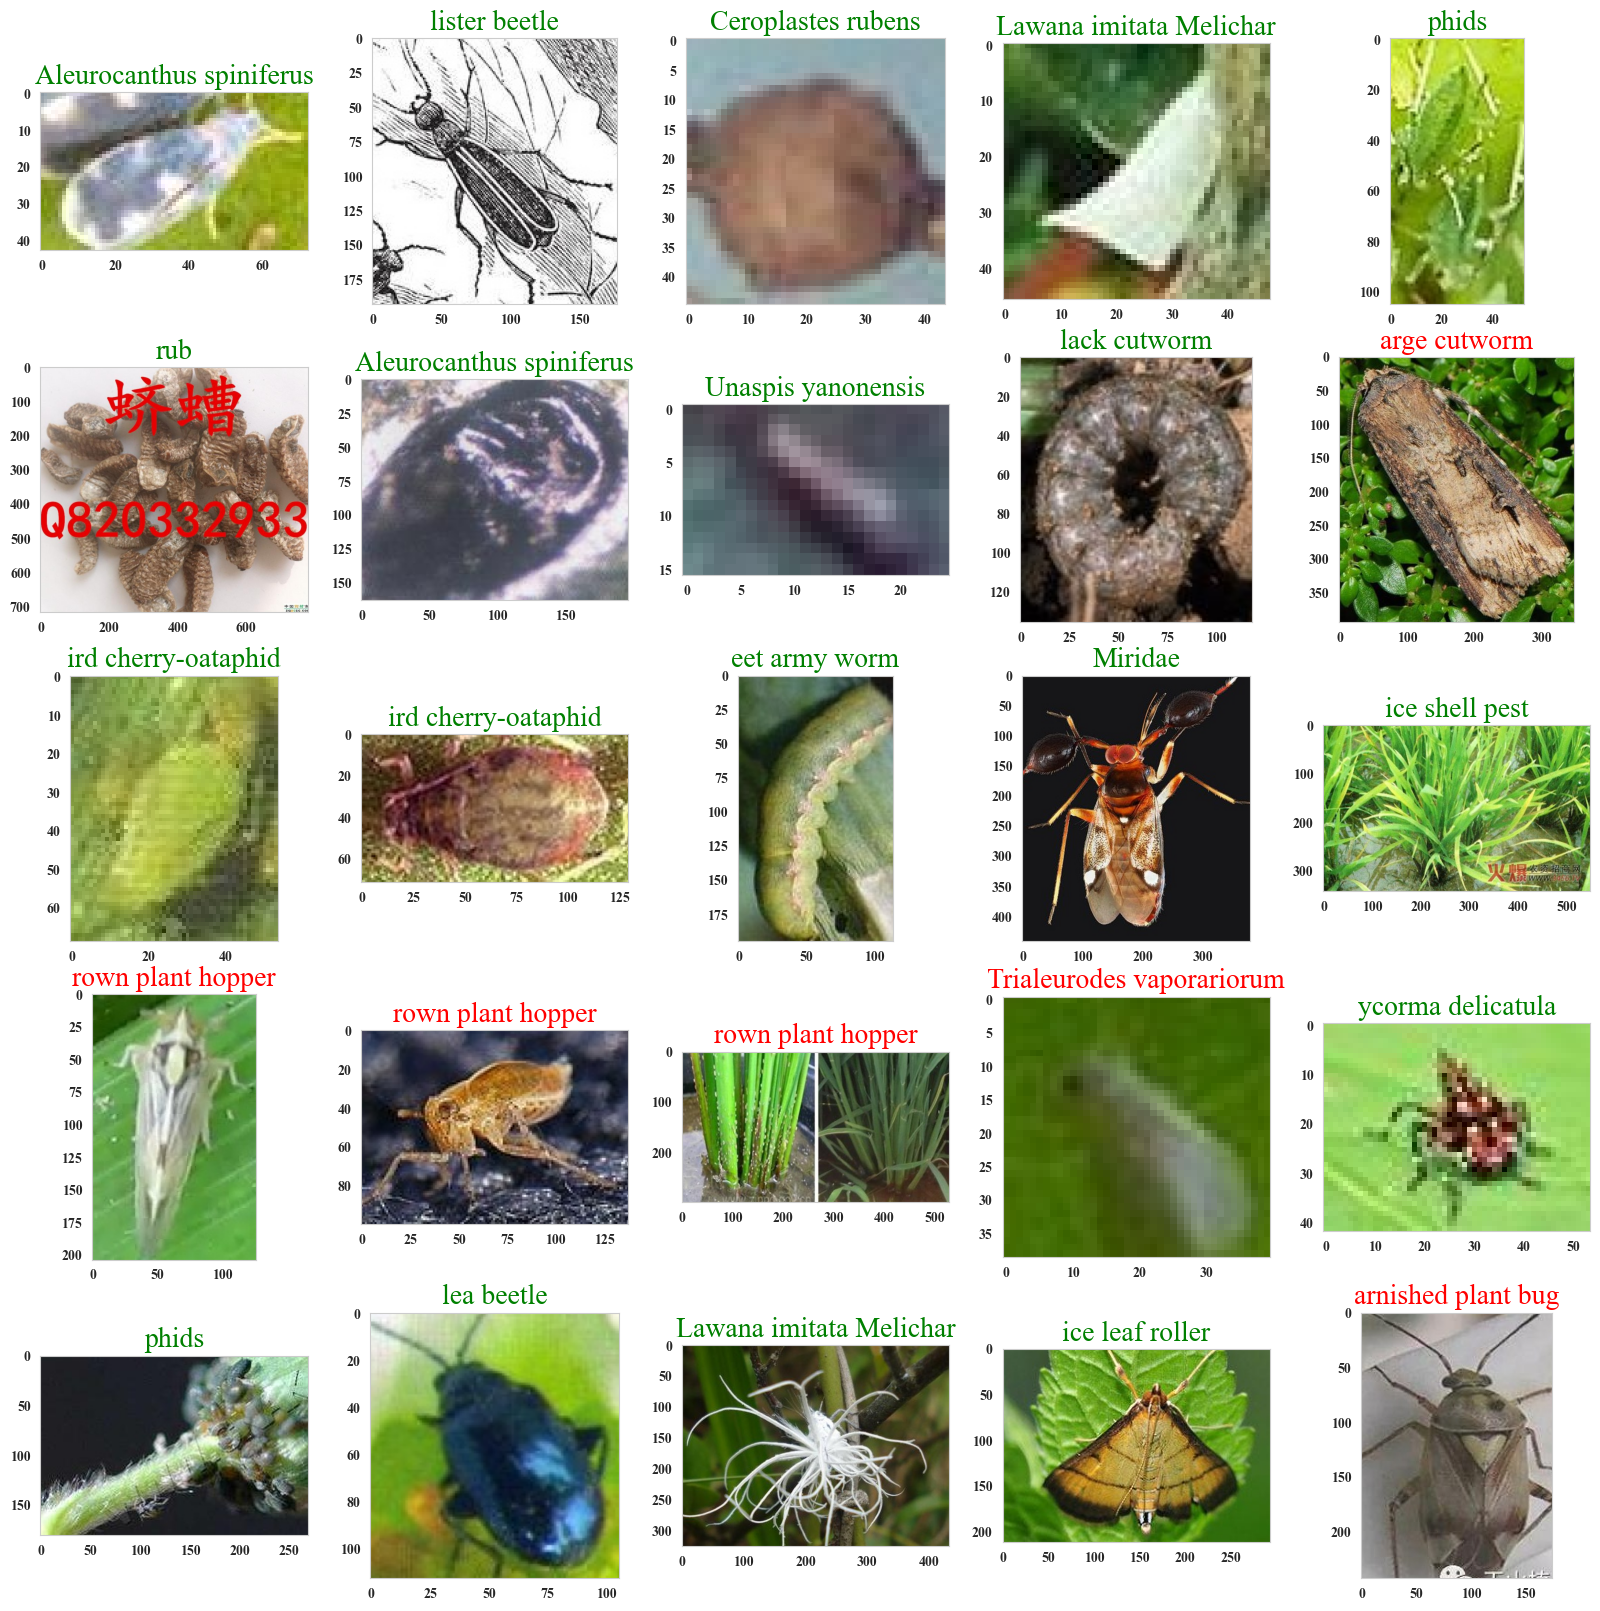

In [165]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.to(device)
model_ft.eval()
def test_by_img(img_path,model,class_real_names):
    with open("datasets/classes.txt", "r") as f:
        lines = f.readlines()
        lines = [i.strip() for i in lines]
        no_trans_class_names = lines
    img = Image.open(img_path)
    img1 = data_transforms['test'](img)
    inputs = img1.unsqueeze(0)
    inputs = inputs.to(device)
    outputs = model(inputs)
    inputs = inputs.cpu()
    _, preds = torch.max(outputs, 1)
    pred = preds[0].cpu().numpy()
    pred_name = class_real_names[int(pred)]
    true_name = img_path.split('/')[-1].split('\\')[0]
    true_name = no_trans_class_names[int(true_name)]
    plt.grid(False)
    if pred_name == true_name:
        plt.title(f'{pred_name}',color='green',fontsize=20)
    else:
        plt.title(f'{pred_name}',color='red',fontsize=20)
    # plt.axis('off')
    plt.imshow(img)
# test_by_img('datasets/yolo_data/test/101/70109.jpg',model_ft,class_real_names)
img_num = 25
plt.figure(figsize=(20,20))
files_list = set()
for root, dirs, files in os.walk('datasets/yolo_data/test/'):
    if len(files) != 0:
        for file in files:
            files_list.add(os.path.join(root,file))
    # 随机选取img_num张
cnt = 1
files_list = random.sample(files_list,img_num)
for file in files_list:
    plt.subplot(5,5,cnt)
    test_by_img(file,model_ft,class_real_names)
    cnt += 1
    if cnt > img_num:
        break

## 5.3 验证spinalNet模型

                                 precision    recall  f1-score   support

                ice leaf roller     0.6444    0.8657    0.7389       335
           ice leaf caterpillar     0.5000    0.3878    0.4368       147
               ice water weevil     0.7922    0.7860    0.7891       257
          Sternochetus frigidus     0.7440    0.6739    0.7072       138
                   Cicadellidae     0.9039    0.8955    0.8997      1723
                 ice leafhopper     0.5657    0.4590    0.5068       122
           rain spreader thrips     0.7273    0.4615    0.5647        52
                 ice shell pest     0.5424    0.2602    0.3516       123
                            rub     0.8868    0.9109    0.8987       258
                    ole cricket     0.9857    0.9737    0.9797       495
                        ireworm     0.8901    0.9101    0.9000       267
             hite margined moth     0.6875    0.2444    0.3607        45
                   lack cutworm     0.5065    0.75

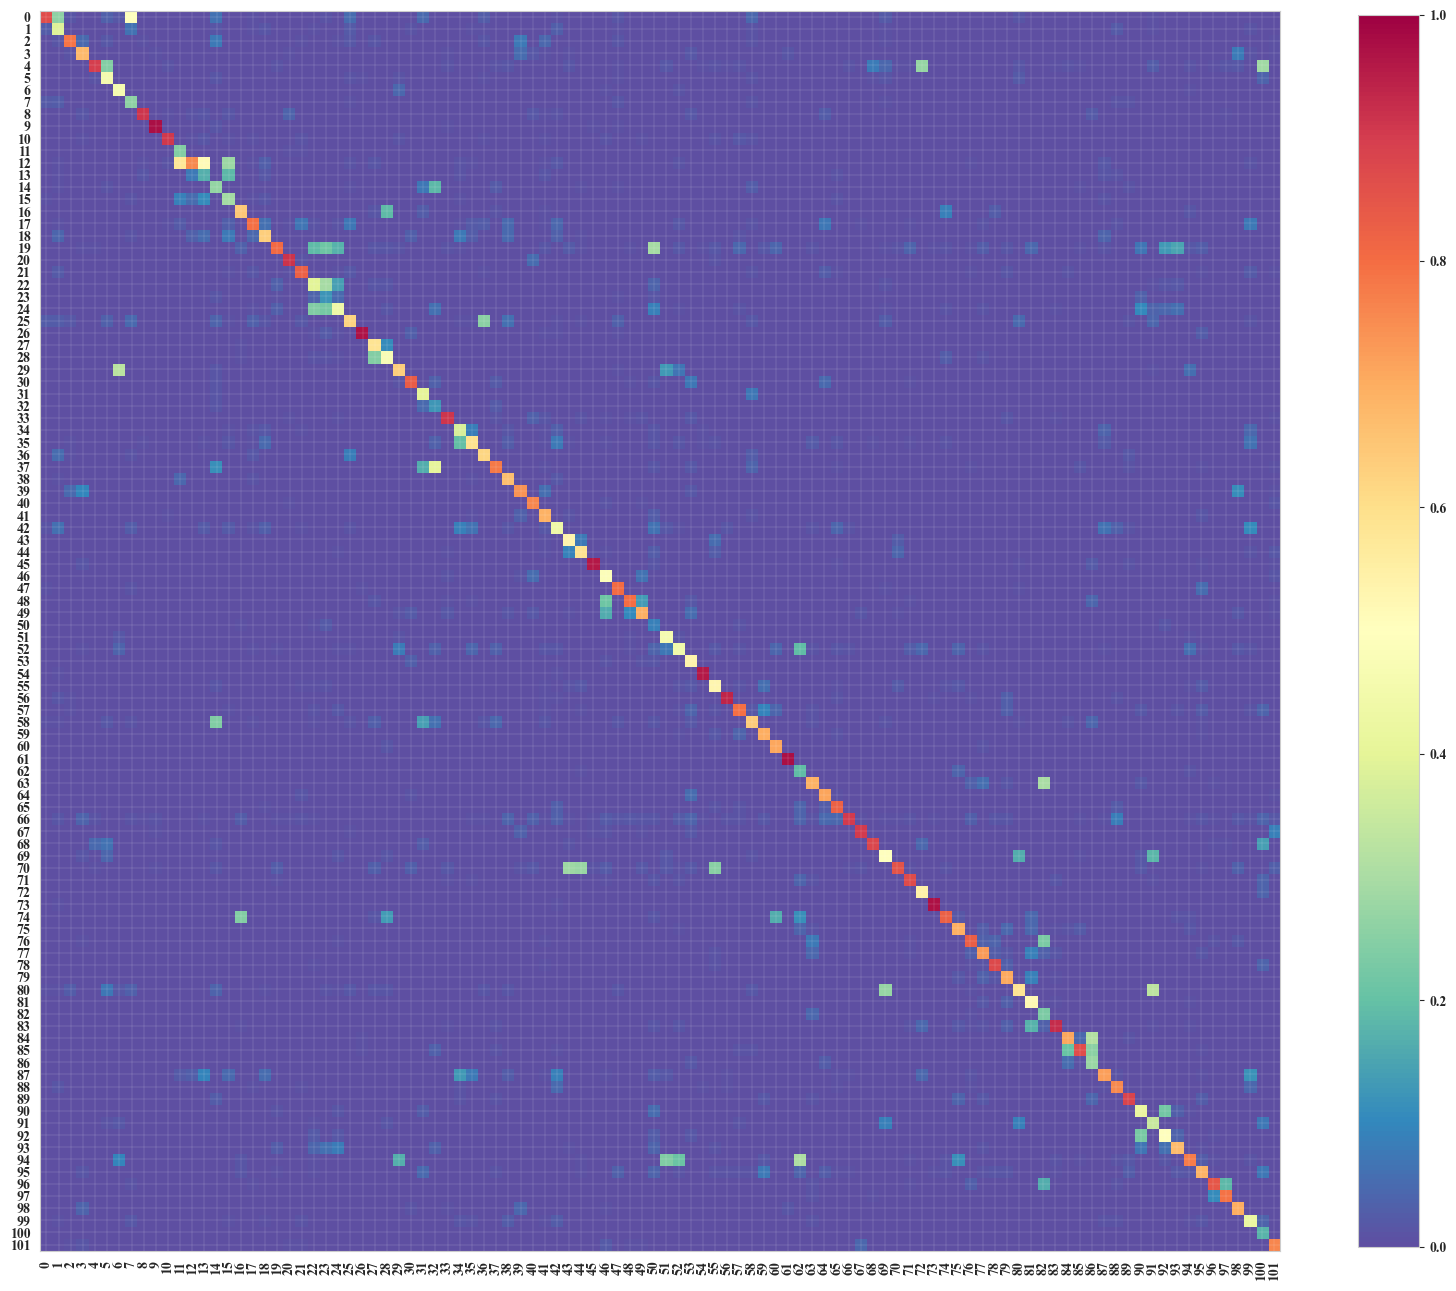

In [77]:
heat_map1 = test_by_csv('model/label_spinalNet.csv',class_real_names.values())

## 5.4 验证baseline模型

                                 precision    recall  f1-score   support

                ice leaf roller     0.5991    0.8388    0.6990       335
           ice leaf caterpillar     0.3833    0.3129    0.3446       147
               ice water weevil     0.7393    0.7393    0.7393       257
          Sternochetus frigidus     0.7355    0.6449    0.6873       138
                   Cicadellidae     0.8623    0.9193    0.8899      1723
                 ice leafhopper     0.6232    0.3525    0.4503       122
           rain spreader thrips     0.6875    0.4231    0.5238        52
                 ice shell pest     0.6286    0.1789    0.2785       123
                            rub     0.8525    0.9186    0.8843       258
                    ole cricket     0.9778    0.9778    0.9778       495
                        ireworm     0.8328    0.9139    0.8714       267
             hite margined moth     0.7222    0.2889    0.4127        45
                   lack cutworm     0.5312    0.72

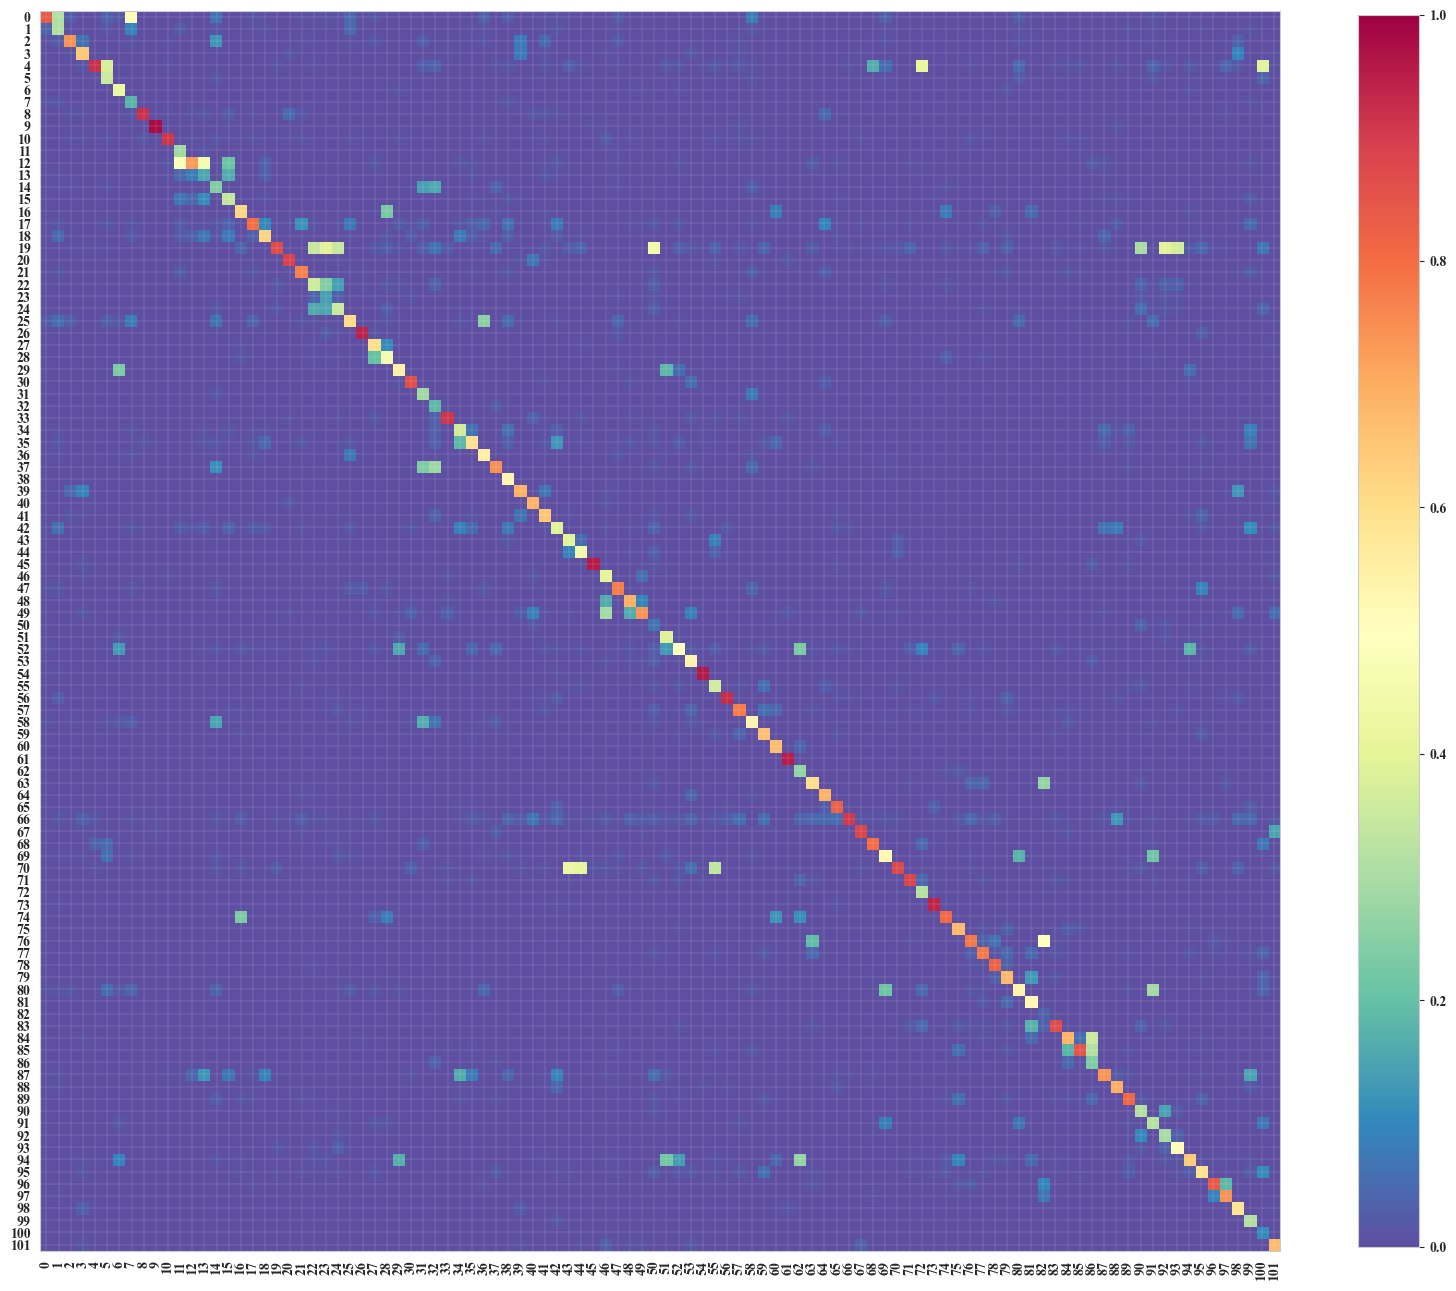

In [78]:
heat_map2 = test_by_csv('model/label_baseline.csv',class_real_names.values())

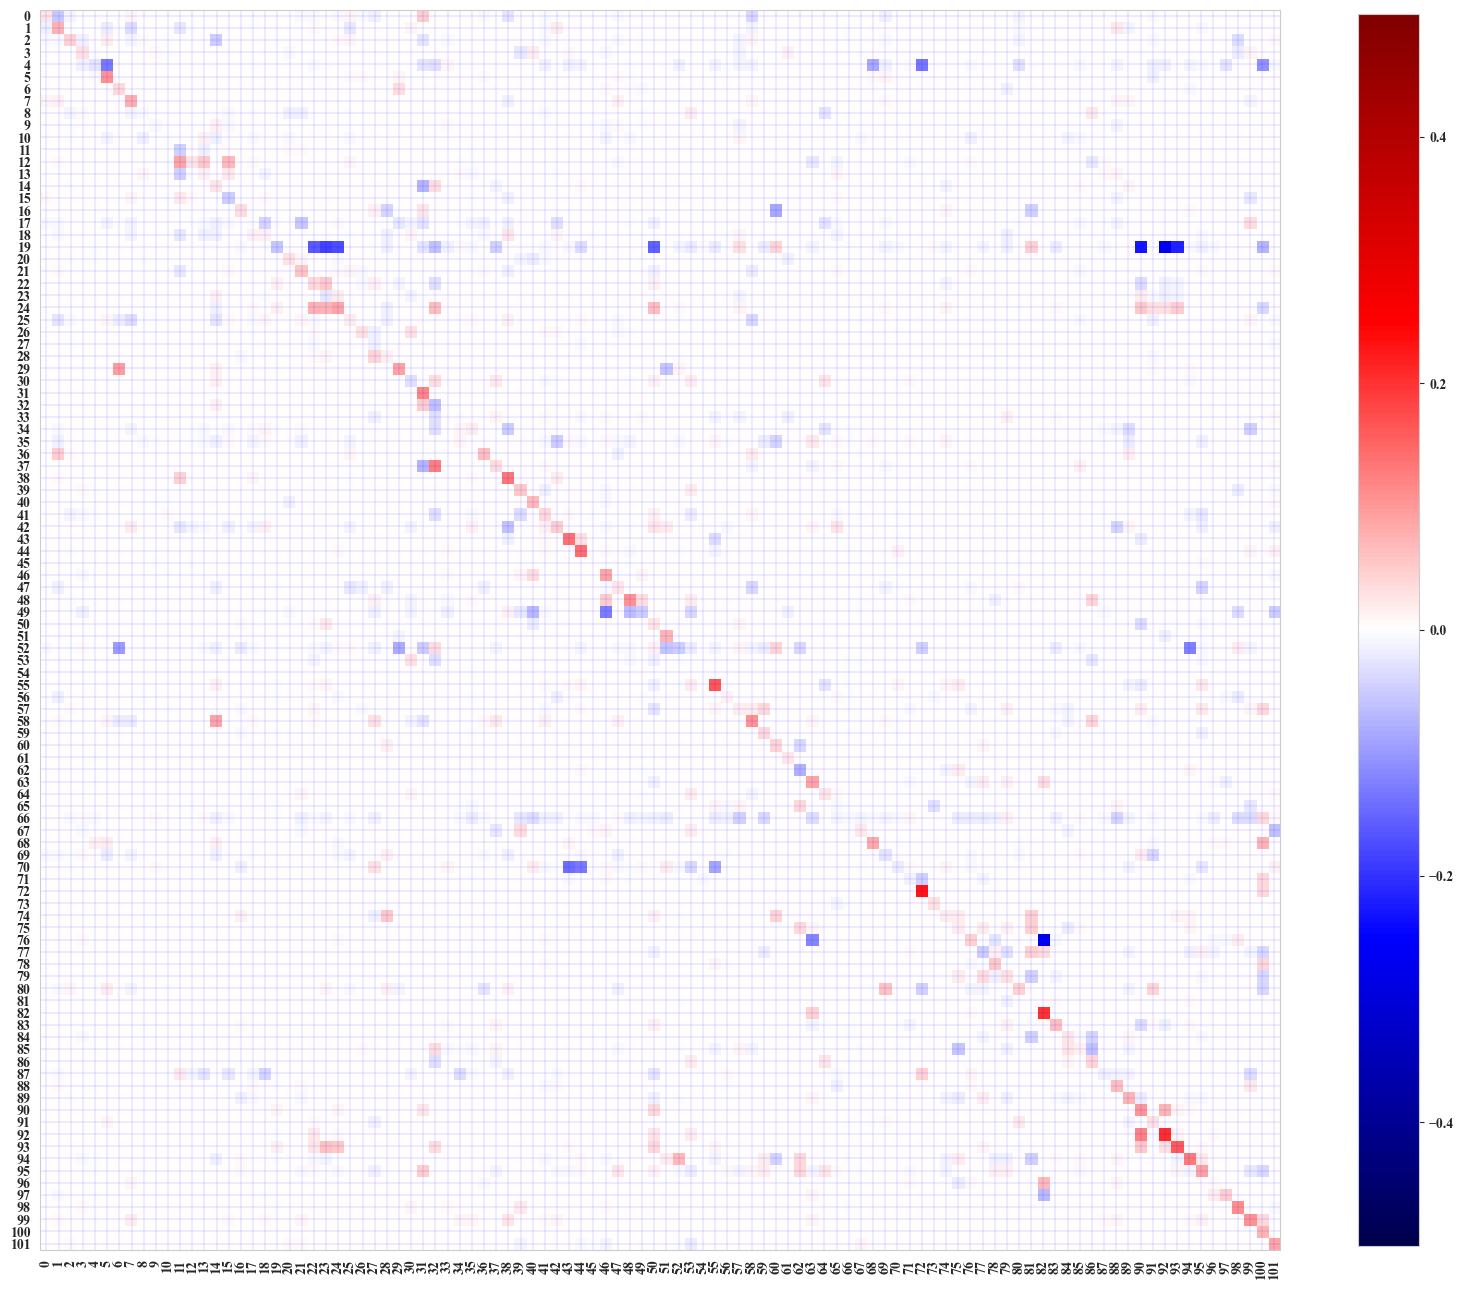

In [124]:
# 绘制heat_map与heat_map2的差值
# 绘制对比矩阵
heat_map_diff = (heat_map1 - heat_map2)
plt.figure(figsize=(20,20))
plt.imshow(heat_map_diff,cmap= 'seismic' , interpolation='nearest', vmin=-0.5, vmax=0.5)
plt.xticks(np.arange(102), np.arange(102), rotation=90)
plt.yticks(np.arange(102), np.arange(102))
plt.colorbar(shrink=0.8, aspect=20)
plt.grid(color='blue', linestyle='-', linewidth=0.1)